In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
def ReLU(x):
    return np.maximum(0, x)

In [25]:
def softmax(x):
    # exponents = np.exp(x)
    # return exponents / np.sum(exponents, axis=0)

    # Subtract the maximum value from x for numerical stability
    shift_x = x - np.max(x, axis=0, keepdims=True)
    exponents = np.exp(shift_x)
    return exponents / np.sum(exponents, axis=0, keepdims=True)

In [26]:
class SparseCategoricalCrossEntropy():
    @staticmethod
    def loss(y, y_pred, logits=True, epsilon=1e-35):
        """
        Calculates and returns the loss of the prediction
        Args:
            y (np.array, shape=(1,m)) : The label of the output (range: 0 to n-1)
            y_pred (np.array, shape=(n, m)) : The output probabilities

        Returns:
            loss (np.float) : The categorical cross entropy loss wrt to given predictions
        """

        # Take each of the y values and convert to one hot vectors
        y_expanded = np.zeros(y_pred.shape)
        y_expanded[y, np.arange(y_expanded.shape[1])] = 1

        if logits:
            y_pred = softmax(y_pred)
            gradient = y_pred - y_expanded
        else:
            gradient = (1 / y_pred ) * y_expanded
        loss = -1 * np.sum(np.log(y_pred + epsilon) * y_expanded) / y_pred.shape[1]
        
        return loss, gradient
    
    @staticmethod
    def gradient(y, y_pred):
        """
        Returns the gradients of the loss wrt to the output probabilities
        Args:
            y (int) : The label of the output (range: 0 to n-1)
            y_pred (np.array, shape=(n,)) : The output probabilities

        Returns:
            dL_dpred (array, shape=(n,)) : The gradients of loss wrt to the probabilities
        """

        gradient = np.zeros(y_pred.shape)
        gradient[y] = -1 / y_pred[y]

        return gradient


In [27]:
class NNLayer():
    def __init__(self, input_shape, output_shape, activation=None, W=None, b=None, dtype=np.float64):
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.X = np.zeros(input_shape)
        self.W = np.random.randn(input_shape, output_shape) if W is None else W
        self.b = np.random.randn(output_shape, 1) if b is None else b
        self.activation = activation # One of None, 'ReLU' or 'softmax'
        self.dW = np.zeros(self.W.shape)
        self.db = np.zeros(self.b.shape)
        self.dz = np.zeros(self.output_shape)
        self.a = 0

        self.dtype = dtype


    def display(self):
         print(f"This layer has an input shape of {self.input_shape}")
         print(f"This layer has an output shape of {self.output_shape}")
         print("\nThe Weights are, ")
         print(self.W)
         print("\nThe biases are: ")
         print(self.b)
         print("\nThe gradients of W are: ")
         print(self.dW)
         print("\nThe gradients of b are: ")
         print(self.db)


    def forward(self, X, inference=False):
        """
        Args:
            X (np.array, 1 dimensional vector) : Input Vector, outptut of the previous NN layer

        Returns:
            W (np.array, 1 dimenstional vector) : The outputs of each neuron in the layer
        """

        # Save the input, will be used during backpropogation
        self.X = X if not inference else self.X

        # Multiply the inputs by weights and add the bias
        z = np.matmul(self.W.T, X) + self.b

        # Apply the activation function
        if self.activation == 'ReLU':
            self.a = ReLU(z)
        elif self.activation == 'softmax':
            self.a = softmax(z)
        else:
            self.a = z
            
        return self.a
    
    def backward(self, gradient):
        """
        Args:
            gradient (np.array, 1 dimensional vector) : The gradient of loss wrt to the output of the layer dL/da 
        
        Returns:
            dL/dX (np.array, shape=(input_shape,)) : The gradient of loss wrt to the input of the layer
        """

        ## 1. First compute the gradient of loss wrt to z
        if self.activation == None:
            dz = gradient.astype(np.float32)
        elif self.activation == 'ReLU':
            dz = (np.greater(self.a, 0) * gradient).astype(self.dtype)
        else:
            raise Exception("Activation funciton not found. Check the activation is either None or ReLU")


        ## 2. Use dL/dz to compute dw, db, dX
        self.dW = np.matmul(self.X, dz.T).astype(self.dtype)
        self.db = np.sum(dz, axis=1).reshape(-1, 1).astype(self.dtype)
        dX = np.matmul(self.W, dz).astype(self.dtype)

        return dX
    
    def update_parameters(self, training_samples, learning_rate):
        ## Get the average of the gradients
        self.dW = self.dW / training_samples
        self.db = self.db / training_samples

        ## Update
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db



In [28]:
class FeedForwardNeuralNetwork():
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)

    def train(self, X_train, y_train, X_test=None, y_test=None, epochs=100, learning_rate=0.1):
        training_losses = []
        training_accuracy = []
        validation_losses = []
        validation_accuracy = []
        #### Training Loop
        for epoch in range(epochs):
            print(f"Training ... Epoch: {epoch} | ", end=" ")

            ### Forward pass
            a = X_train.copy()
            for layer in self.layers:
                a = layer.forward(a)

            ### Calculate the loss
            loss, gradient = SparseCategoricalCrossEntropy.loss(y=y_train, y_pred=a, logits=True)
            training_losses.append(loss)

            accuracy = np.mean(np.argmax(self.predict(X_train, apply_softmax=True), axis=0) == y_train)
            training_accuracy.append(accuracy)

            print("Loss: ", loss, " | Accuracy: ", accuracy)

            ### Backward pass
            for layer in reversed(self.layers):
                gradient = layer.backward(gradient)
                layer.update_parameters(training_samples=X_train.shape[1], learning_rate=learning_rate)


            ### Validation
            if X_test is not None and y_test is not None:
                ### Forward pass
                a_test = X_test
                for layer in self.layers:
                    a_test = layer.forward(a_test, inference=True)

                loss_test, _ = SparseCategoricalCrossEntropy.loss(y=y_test, y_pred=a_test, logits=True)
                validation_losses.append(loss_test)

                accuracy= np.mean(np.argmax(self.predict(X_test, apply_softmax=True), axis=0) == y_test)
                validation_accuracy.append(accuracy)


        return training_losses, validation_losses, training_accuracy, validation_accuracy


    def predict(self, X, apply_softmax=False):
        a = X
        for layer in self.layers:
            a = layer.forward(a, inference=True)

        if apply_softmax:
            a = softmax(a)
        
        return a

            

In [29]:
X_train_df = pd.read_csv('Task_2/x_train.csv', header=None)
X_train = X_train_df.to_numpy().T

y_train_df = pd.read_csv('Task_2/y_train.csv', header=None)
y_train = y_train_df.to_numpy().squeeze()

In [30]:
# X_train = np.array([
#     [-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1],
#     [-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1],
#     [-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1]
# ]).T
# y_train = np.array([3,3,3])

In [31]:
X_train.shape, y_train.shape

((14, 13107), (13107,))

In [32]:
X_test_df = pd.read_csv('Task_2/x_test.csv', header=None)
X_test = X_test_df.to_numpy().T

y_test_df = pd.read_csv('Task_2/y_test.csv', header=None)
y_test = y_test_df.to_numpy().squeeze()

In [33]:
X_test.shape, y_test.shape

((14, 3277), (3277,))

In [34]:
NUM_LAYERS = 4 # Inclusive of input and output layers
LAYER_SIZES = [14, 100, 40, 4]

np.random.seed(26)

NN = FeedForwardNeuralNetwork()
NN.add_layer(NNLayer(LAYER_SIZES[0], LAYER_SIZES[1], activation='ReLU'))
NN.add_layer(NNLayer(LAYER_SIZES[1], LAYER_SIZES[2], activation='ReLU'))
NN.add_layer(NNLayer(LAYER_SIZES[2], LAYER_SIZES[3]))


In [35]:
EPOCHS = 150
training_losses, validation_losses, training_accuracy, validation_accuracy = NN.train(X_train=X_train,
                                              y_train=y_train,
                                              X_test=X_test,
                                              y_test=y_test, 
                                              epochs=EPOCHS,
                                              learning_rate=0.01)

Training ... Epoch: 0 |  Loss:  49.687332139673934  | Accuracy:  0.2711528191042954
Training ... Epoch: 1 |  Loss:  45.05547525579005  | Accuracy:  0.27222095063706414
Training ... Epoch: 2 |  

Loss:  42.559115189662265  | Accuracy:  0.2739757381551843
Training ... Epoch: 3 |  Loss:  40.863401377230154  | Accuracy:  0.2734416723887999
Training ... Epoch: 4 |  Loss:  39.48607457737088  | Accuracy:  0.27664606698710614
Training ... Epoch: 5 |  Loss:  38.27517144026227  | Accuracy:  0.2743572137026017
Training ... Epoch: 6 |  Loss:  37.14937465691496  | Accuracy:  0.2743572137026017
Training ... Epoch: 7 |  Loss:  36.142006636277834  | Accuracy:  0.2776379034103914
Training ... Epoch: 8 |  Loss:  35.2440018005657  | Accuracy:  0.2767986572060731
Training ... Epoch: 9 |  Loss:  34.413899547662176  | Accuracy:  0.2768749523155566
Training ... Epoch: 10 |  Loss:  33.63961360832038  | Accuracy:  0.2790112153810941
Training ... Epoch: 11 |  Loss:  32.911872127559  | Accuracy:  0.2809948882276646
Training ... Epoch: 12 |  Loss:  32.21741252263513  | Accuracy:  0.2809948882276646
Training ... Epoch: 13 |  Loss:  31.54539801946988  | Accuracy:  0.2830548561837186
Training ... Epoch: 14 

Text(0.5, 1.0, 'Training and Validation Loss')

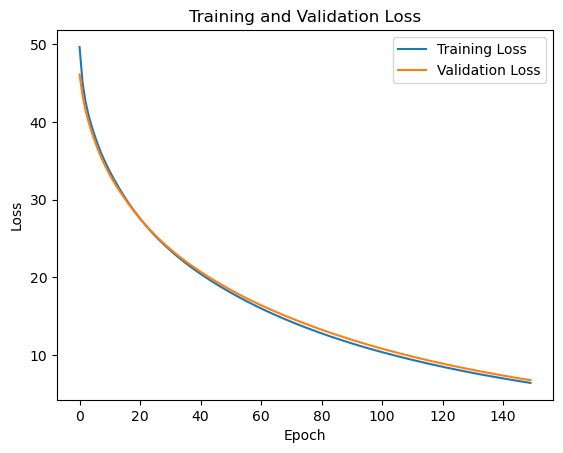

In [36]:
x = np.arange(EPOCHS)

plt.plot(x, training_losses, label='Training Loss')
plt.plot(x, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

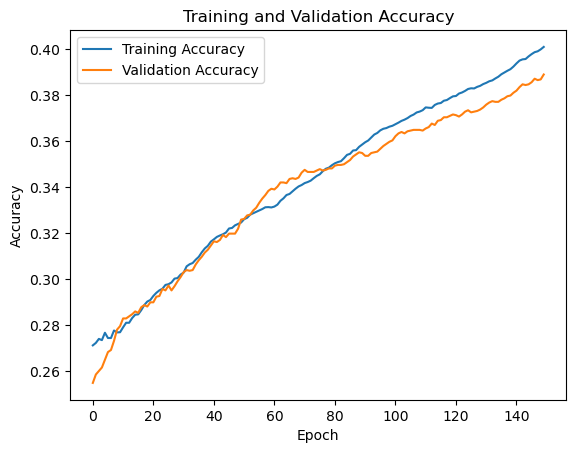

In [37]:
plt.plot(x, training_accuracy, label='Training Accuracy')
plt.plot(x, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [38]:
# # initial_weights = pd.read_csv('Task_1/b/w-100-40-4.csv', header=None)
# initial_weights = pd.read_csv('Task_1/a/w.csv', header=None)
# # initial_biases = initial_weights = pd.read_csv('Task_1/b/b-100-40-4.csv', header=None)
# initial_biases = pd.read_csv('Task_1/a/b.csv', header=None)
# X_train = np.array([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1]) # As given in data_point.txt
# w1 = initial_weights.iloc[0:14, 1:].to_numpy().astype(np.float32)
# w2 = initial_weights.iloc[14:114, 1:41].to_numpy().astype(np.float32)
# w3 = initial_weights.iloc[114:, 1:5].to_numpy().astype(np.float32)
# b1 = initial_biases.iloc[0, 1:].to_numpy().reshape(-1,1).astype(np.float32)
# b2 = initial_biases.iloc[1, 1:41].to_numpy().reshape(-1,1).astype(np.float32)
# b3 = initial_biases.iloc[2, 1:5].to_numpy().reshape(-1,1).astype(np.float32)

In [39]:
# NUM_LAYERS = 4 # Inclusive of input and output layers
# LAYER_SIZES = [14, 100, 40, 4]

# NN = FeedForwardNeuralNetwork()
# NN.add_layer(NNLayer(LAYER_SIZES[0], LAYER_SIZES[1], W=w1, b=b1, activation='ReLU'))
# NN.add_layer(NNLayer(LAYER_SIZES[1], LAYER_SIZES[2], W=w2, b=b2, activation='ReLU'))
# NN.add_layer(NNLayer(LAYER_SIZES[2], LAYER_SIZES[3], W=w3, b=b3))

In [40]:
np.argmax(NN.predict(X_train[:, 0].reshape(14,1), apply_softmax=True)), y_train[0]

(3, 3)

In [41]:
SparseCategoricalCrossEntropy.loss(y_train, NN.predict(X_train[:, 0].reshape(14,1), apply_softmax=False))

(32.88805182310379,
 array([[-0.99999853],
        [-0.99999992],
        [-0.95397   ],
        [-0.04603156]]))

In [42]:
correct = 0
for i in range (X_train.shape[1]):
    correct += np.argmax(NN.predict(X_train[:, i].reshape(14,1), apply_softmax=True)) == y_train[i]
correct

5264

In [43]:

np.sum(np.argmax(NN.predict(X_train.reshape(14,-1), apply_softmax=True), axis=0) == y_train)


5264

In [44]:
np.sum(np.argmax(NN.predict(X_test.reshape(14,-1), apply_softmax=True), axis=0) == y_test)

1275